In [4]:
import py21cmfast as p21c
from matplotlib import pyplot as plt
import os 
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)
from py21cmfast import plotting
from py21cmfast import cache_tools
from multiprocessing import Pool
import timeit
import numpy as np
import random
import yaml

if not os.path.exists('_cache'):
    os.mkdir('../_cache')

p21c.config['direc'] = '../_cache'
# cache_tools.clear_cache(direc="../_cache")

print(f"Using 21cmFAST version {p21c.__version__}")

/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
2024-04-29 09:36:56,737 | INFO | Removed 139 files from cache.


Using 21cmFAST version 3.3.1


use astro_params default config: True
use cosmo_params default config: True
use user_params default config: False
use flag_options default config: True
use global_params default config: True


/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vz
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vx_2LPT
  warnings.warn(f"Tr

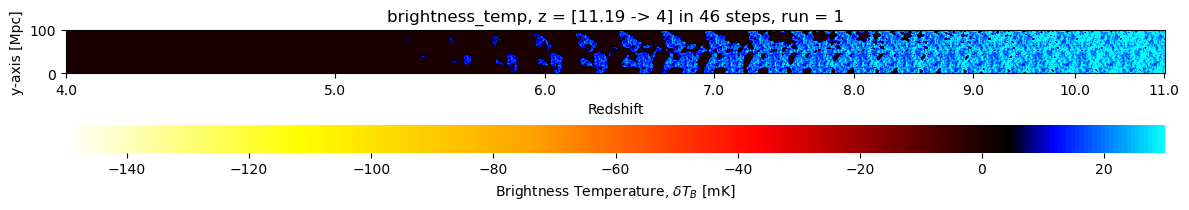

In [6]:
class parameters():    
    '''Initialize parameter given a config file'''
    def __init__(self, random_seed=True, parameter_path="./"):
        self.prechange = True
        self.random_seed = random_seed
        with open(parameter_path + "parameter.yaml", 'r') as file:
            parameter = yaml.safe_load(file)
        
        
        
        use_default = []
        for key in parameter.keys():
            if key == "input_params":
                self.input_params = parameter["input_params"]
            else:
                print(f"use {key} default config: {parameter[key]["use_default"]}")
                use_default.append(parameter[key]["use_default"])
                parameter[key].pop("use_default")
        parameter.pop("input_params")
        
        self.astro_params = parameter["astro_params"] if not use_default[0] else p21c.AstroParams()
        self.cosmo_params = parameter["cosmo_params"] if not use_default[1] else p21c.CosmoParams()
        self.user_params = parameter["user_params"] if not use_default[2] else p21c.UserParams()
        self.flag_params = parameter["flag_options"] if not use_default[3] else p21c.FlagOptions()
        self.global_params = parameter["global_params"] if not use_default[4] else {}
        parameter.pop("global_params")
        
        self.input_params.update(parameter)
        self.standard_config = self.input_params.copy() 
        
    def kwargs_update(self, kargs):
        self.input_params.update(kargs)
        
            
    def pbox_run(self, zsteps):
        if self.prechange:
            self.prechange = False
            self.lcone_quantities = self.input_params.pop("lightcone_quantities")
            self.z = [self.input_params["redshift"] + (self.input_params["max_redshift"] - self.input_params["redshift"])/zsteps * i for i in range(zsteps+1)] 
            self.input_params["redshift"] = self.z
            self.input_params.pop("max_redshift")
        else:
            self.prechange = False
            self.input_params["lightcone_quantities"] = self.lcone_quantities
            self.input_params["redshift"] = self.z[0]
            self.input_params["max_redshift"] = self.z[-1]
            
    def randomize(self):
        self.input_params["random_seed"] = random.randint(0,99999)
                
            
    
        
        
    
class simulation(parameters):
    '''Dynamically execute and plot simulation'''
    def __init__(self, random_seed=True):
        super().__init__(random_seed=random_seed)
        self.data = []
        
    def __len__(self):
        return len(self.data)
        
    def run_box(self, runs, zsteps, kargs={}):
        self.simtype = 0
        self.pbox_run(zsteps)
        with p21c.global_params.use(**self.global_params):
            for _ in range(runs):
                self.kwargs_update(kargs)
                self.data.append(p21c.run_coeval(**self.input_params))
        self.pbox_run(zsteps)
    
    def run_lightcone(self, runs, kargs={}):
        self.simtype = 1
        with p21c.global_params.use(**self.global_params):
            for _ in range(runs):
                self.kwargs_update(kargs)
                self.data.append(p21c.run_lightcone(**self.input_params))
        
    def plot(self, fields=["brightness_temp"]):
        match self.simtype:
            case 0:
                h = len(self.data)
                w = len(self.data[0])
                fig, ax = plt.subplots(h,w, figsize=(4*w,4*h))
                ax = ax.reshape(h,w)
                for field in fields:
                    for (j, axis) in zip(range(len(self.data)),  ax):
                        for i, (dat, redshift, a) in enumerate(zip(self.data[j], [z.redshift for z in test.data[j]], axis)):
                            if i<1:
                                plotting.coeval_sliceplot(dat, ax=a, fig=fig, kind=field)
                            else:
                                plotting.coeval_sliceplot(dat, ax=a, fig=fig, kind=field, printlabel=False)
                            plt.title(f"{field}, z = {round(redshift,2)}")
                    plt.tight_layout()
                    plt.show()
            case 1:
                h = len(self.data)
                fig, ax = plt.subplots(h,1, figsize=(12,4*h))
                ax = ax.flatten() if h > 1 else [ax]
                for field in fields:
                    for i, dat in enumerate(self.data):
                        z = dat.node_redshifts
                        plotting.lightcone_sliceplot(dat, ax=ax[i], fig=fig, kind=field)
                        plt.title(f"{field}, z = [{round(max(z),2)} -> {round(min(z),2)}] in {len(z)} steps, run = {i+1}")
                    ax = np.reshape(ax, (h,1))
                    plt.tight_layout()
                    plt.show()     
        

        
    def pop(self,idx):
        self.data.pop(idx)
        
    def clear(self):
        self.data.clear()

params = {"redshift": 4, "max_redshift": 11}

test = simulation(random_seed=False)
test.run_lightcone(runs = 1, kargs=params)
test.plot()

In [55]:
print(yaml.safe_dump({"lightcone_quantities": ('brightness_temp','Ts_box','xH_box',"dNrec_box",'z_re_box','Gamma12_box','J_21_LW_box','density')}))

lightcone_quantities:
- brightness_temp
- Ts_box
- xH_box
- dNrec_box
- z_re_box
- Gamma12_box
- J_21_LW_box
- density



In [7]:
test.data[0].

In [3]:
test.

Type:        dict
String form: {}
Length:      0
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [11]:
p21c.global_params?

Type:        GlobalParams
String form: GlobalParams(ALPHA_UVB=5.0;CLUMPING_FACTOR=2.0;CRIT_DENS_TRANSITION=1.5;DELTA_CRIT_MODE=1;DELTA_R <...> h=<cdata 'char[]' owning 67 bytes>;g_x=1.5;wisdoms_path=<cdata 'char[]' owning 33 bytes>;wl=-1.0)
File:        ~/miniconda3/lib/python3.12/site-packages/py21cmfast/inputs.py
Docstring:  
Global parameters for 21cmFAST.

This is a thin wrapper over an allocated C struct, containing parameter values
which are used throughout various computations within 21cmFAST. It is a singleton;
that is, a single python (and C) object exists, and no others should be created.
This object is not "passed around", rather its values are accessed throughout the
code.

Parameters in this struct are considered to be options that should usually not have
to be modified, and if so, typically once in any given script or session.

Values can be set in the normal way, eg.:

>>> global_params.ALPHA_UVB = 5.5

The class also provides a context manager for setting parameters for

In [23]:
test = {
    "test1": 1,
    "test2": 2
}

In [25]:
if ("d", "test1") in test:
    print(test)

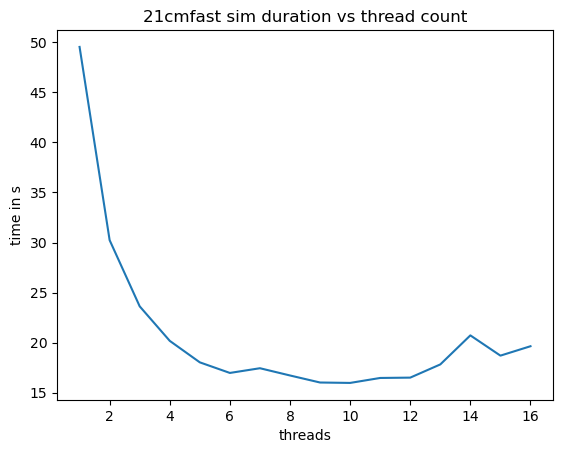

In [17]:
plt.plot([i+1 for i in range(16)], time)
plt.xlabel("threads")
plt.ylabel("time in s")
plt.title("21cmfast sim duration vs thread count")
plt.show()

In [8]:
lightcone = p21c.run_lightcone(
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    direc='_cache',
    user_params=p21c.UserParams(HII_DIM=64, BOX_LEN=256, KEEP_3D_VELOCITIES=True)
)

ValueError: Either redshift must be provided, or a data set containing it.

In [23]:
class tests():
    def __init__(self,t):
        self.t = t
class testing(tests):
    def __init__(self):
        super().__init__(1)


In [26]:
np.rand

Object `np.randint` not found.


In [32]:
np.fromstring(os.urandom(4))

/tmp/ipykernel_3981/1617486966.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  np.fromstring(os.urandom(4))


ValueError: string size must be a multiple of element size

In [128]:
test

{'_cobj': <cdata 'struct GlobalParams &' 0x7285e3468e60>,
 '_ffi': <_cffi_backend.FFI at 0x72869433c660>,
 'EVOLVE_DENSITY_LINEARLY': 0,
 'SMOOTH_EVOLVED_DENSITY_FIELD': 0,
 'R_smooth_density': 0.20000000298023224,
 'HII_ROUND_ERR': 9.999999747378752e-06,
 'FIND_BUBBLE_ALGORITHM': 2,
 'N_POISSON': 5,
 'T_USE_VELOCITIES': 1,
 'MAX_DVDR': 0.20000000298023224,
 'DELTA_R_HII_FACTOR': 1.100000023841858,
 'DELTA_R_FACTOR': 1.100000023841858,
 'HII_FILTER': 1,
 'INITIAL_REDSHIFT': 300.0,
 'R_OVERLAP_FACTOR': 1.0,
 'DELTA_CRIT_MODE': 1,
 'HALO_FILTER': 0,
 'OPTIMIZE': 0,
 'OPTIMIZE_MIN_MASS': 99999997952.0,
 'CRIT_DENS_TRANSITION': 1.5,
 'MIN_DENSITY_LOW_LIMIT': 9.000000034120603e-08,
 'RecombPhotonCons': 0,
 'PhotonConsStart': 0.9950000047683716,
 'PhotonConsEnd': 0.30000001192092896,
 'PhotonConsAsymptoteTo': 0.009999999776482582,
 'PhotonConsEndCalibz': 3.5,
 'HEAT_FILTER': 0,
 'CLUMPING_FACTOR': 2.0,
 'Z_HEAT_MAX': 35.0,
 'R_XLy_MAX': 500.0,
 'NUM_FILTER_STEPS_FOR_Ts': 40,
 'ZPRIME_STEP_FA

In [34]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getattr__(self, name: str):
        return self.__dict__[f"_{name}"]

    def __setattr__(self, name, value):
        self.__dict__[f"_{name}"] = value

In [49]:
x = {'a': {"one": 1}, 
    'b': {"two": 2}}
y = {'a': {"two": 3},'b': {"three": 3} ,'c': {"four": 4}}
x.update(y)

In [50]:
x

{'a': {'two': 3}, 'b': {'three': 3}, 'c': {'four': 4}}